

This project focuses on understanding and segmenting the client base of a commercial bank.

The idea is to take a real dataset of bank customers, analyze their profiles and transaction behaviors,
and use this information to create **meaningful customer segments** that can guide marketing, credit, and product decisions.

The workflow includes:
1. Exploratory Data Analysis — checking data quality, structure, and key patterns;
2. Data Cleaning & Preparation — fixing missing values and encoding categorical variables;
3. Two segmentation approaches:
   - **RFM segmentation** (based on Recency, Frequency, Monetary value);
   - **K-Means clustering** (unsupervised ML segmentation);
4. Cluster Evaluation — determining the optimal number of clusters with multiple metrics;
5. Customer Profiling & Visualization — interpreting and visualizing the resulting segments.



In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
plt.style.use('default')

df = pd.read_csv('HW1_var_14.csv', sep=';', encoding='utf-8-sig')
print(df.shape)
df.head()


(10242, 44)


,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,14,1000014,Форма банка (без печати работодателя),Ремонт,1.0,0.48,женский,1,0,высшее,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14,1000034,2НДФЛ,Другое,0.0,0.59,мужской,1,0,высшее,...,0.0,5.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14,1000054,Форма банка (без печати работодателя),Ремонт,0.0,0.20,женский,0,0,среднее-специальное,...,1.0,7.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,1000074,Поступление зарплаты на счет,Ремонт,1.0,0.43,мужской,1,0,высшее,...,1.0,4.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,1000094,2НДФЛ,Покупка автомобиля,0.0,0.57,женский,0,0,высшее,...,0.0,3.0,86.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
n = len(df)
summary = []
for c in df.columns:
    s = df[c]
    zeros = (s==0).sum() if pd.api.types.is_numeric_dtype(s) else np.nan
    miss = s.isna().sum()
    summary.append([c, s.dtype, s.nunique(), zeros, miss, round(miss/n*100,2)])
pd.DataFrame(summary, columns=['column','dtype','unique','zeros','missing','%missing']).sort_values('%missing', ascending=False).head(20)


,column,dtype,unique,zeros,missing,%missing
23,avg_num_delay,float64,1142,1560.0,6589,64.33
32,all_credits,float64,30,0.0,6577,64.22
34,own_closed,float64,11,2112.0,6577,64.22
33,Active_not_cc,float64,8,1216.0,6577,64.22
36,max_MnthAfterLoan,float64,131,8.0,6577,64.22
37,dlq_exist,float64,2,1572.0,6577,64.22
38,thirty_in_a_year,float64,2,3110.0,6577,64.22
27,num_AccountActive60,float64,4,3331.0,6577,64.22
25,num_AccountActive180,float64,6,2576.0,6577,64.22
26,num_AccountActive90,float64,5,3142.0,6577,64.22


We clean text, impute missing values, and encode categorical features.


In [5]:
df_clean = df.copy()
for c in df_clean.select_dtypes(include=['object']):
    df_clean[c] = df_clean[c].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)

for c in df_clean.select_dtypes(include=[np.number]):
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in df_clean.select_dtypes(include=['object']):
    mode = df_clean[c].mode(dropna=True)
    df_clean[c] = df_clean[c].fillna(mode.iloc[0] if not mode.empty else 'unknown')
    df_clean[c] = df_clean[c].astype('category').cat.codes

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10242 entries, 0 to 10241
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Номер варианта         10242 non-null  int64  
 1   ID                     10242 non-null  int64  
 2   INCOME_BASE_TYPE       10242 non-null  int8   
 3   CREDIT_PURPOSE         10242 non-null  int8   
 4   INSURANCE_FLAG         10242 non-null  float64
 5   DTI                    10242 non-null  float64
 6   SEX                    10242 non-null  int8   
 7   FULL_AGE_CHILD_NUMBER  10242 non-null  int64  
 8   DEPENDANT_NUMBER       10242 non-null  int64  
 9   EDUCATION              10242 non-null  int8   
 10  EMPL_TYPE              10242 non-null  int8   
 11  EMPL_SIZE              10242 non-null  int8   
 12  BANKACCOUNT_FLAG       10242 non-null  float64
 13  Period_at_work         10242 non-null  float64
 14  age                    10242 non-null  float64
 15  EM

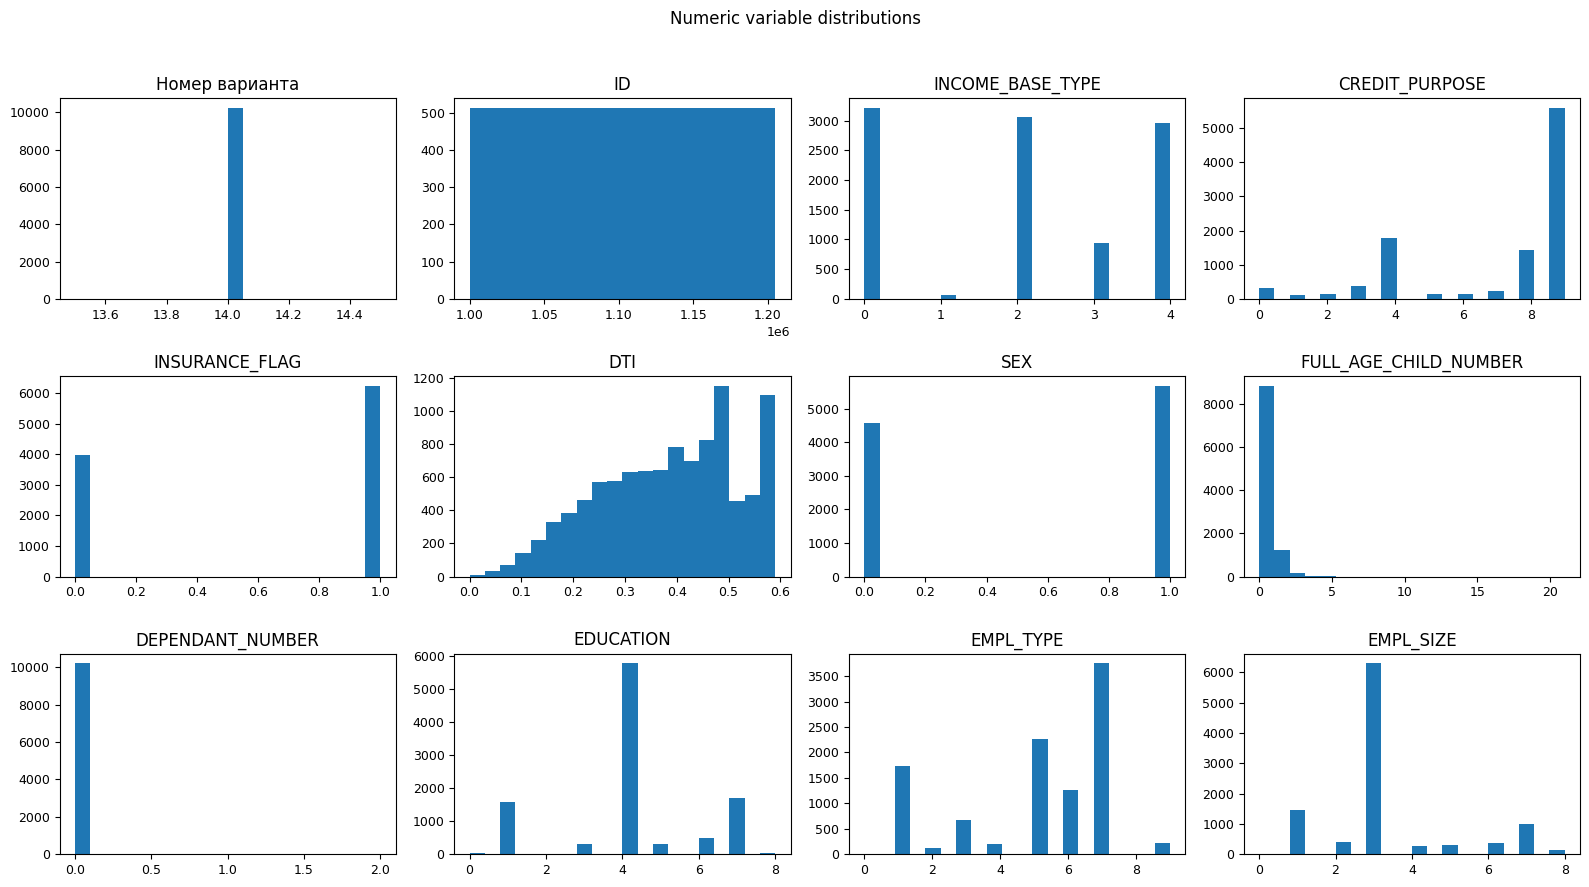

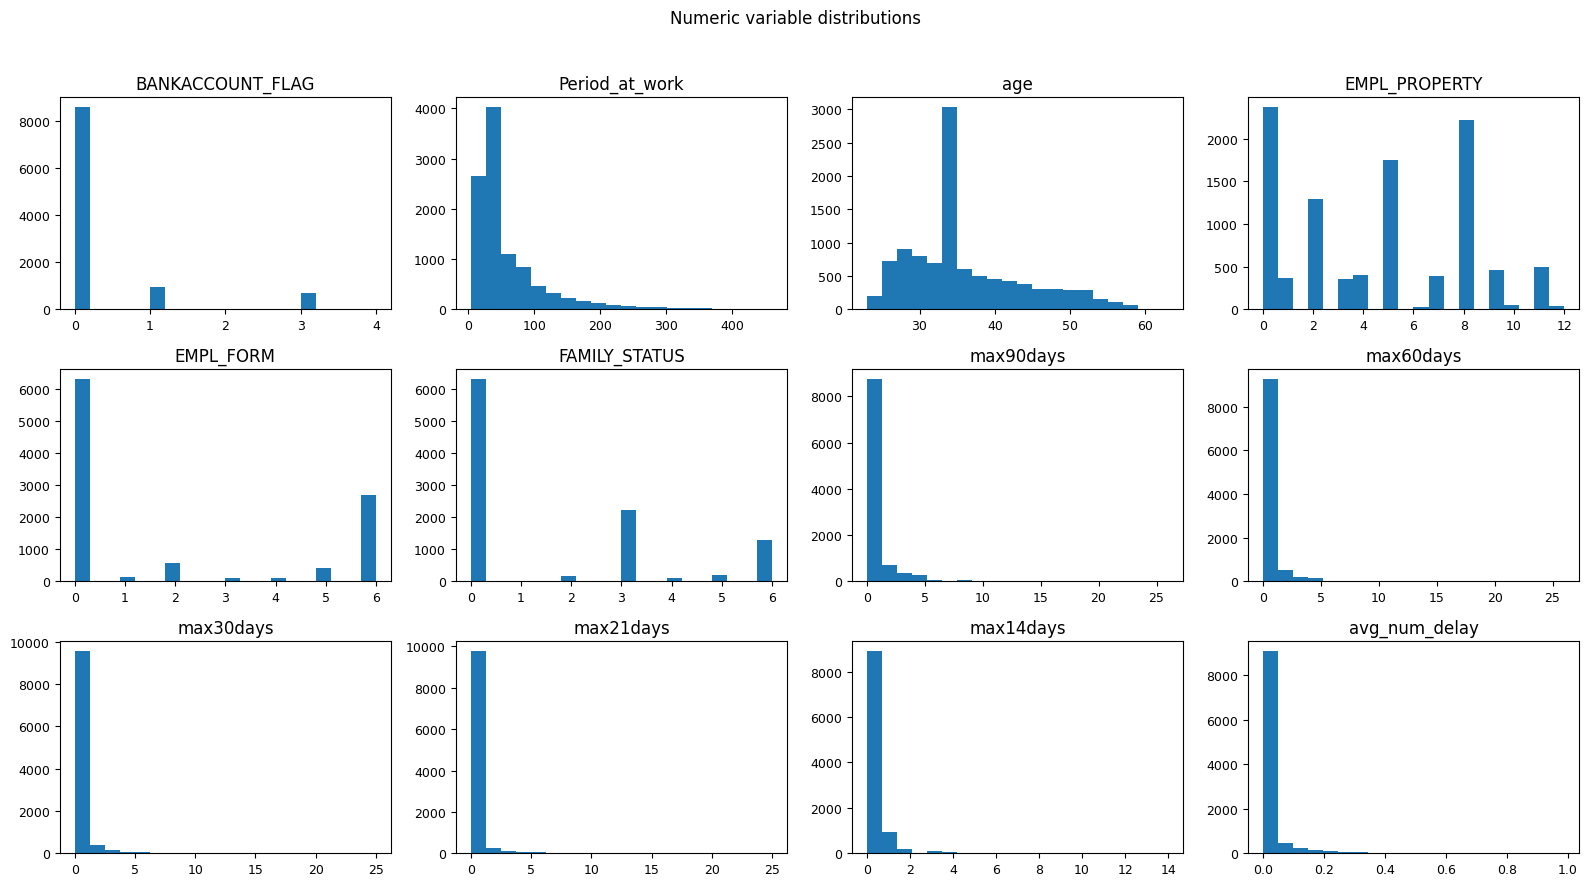

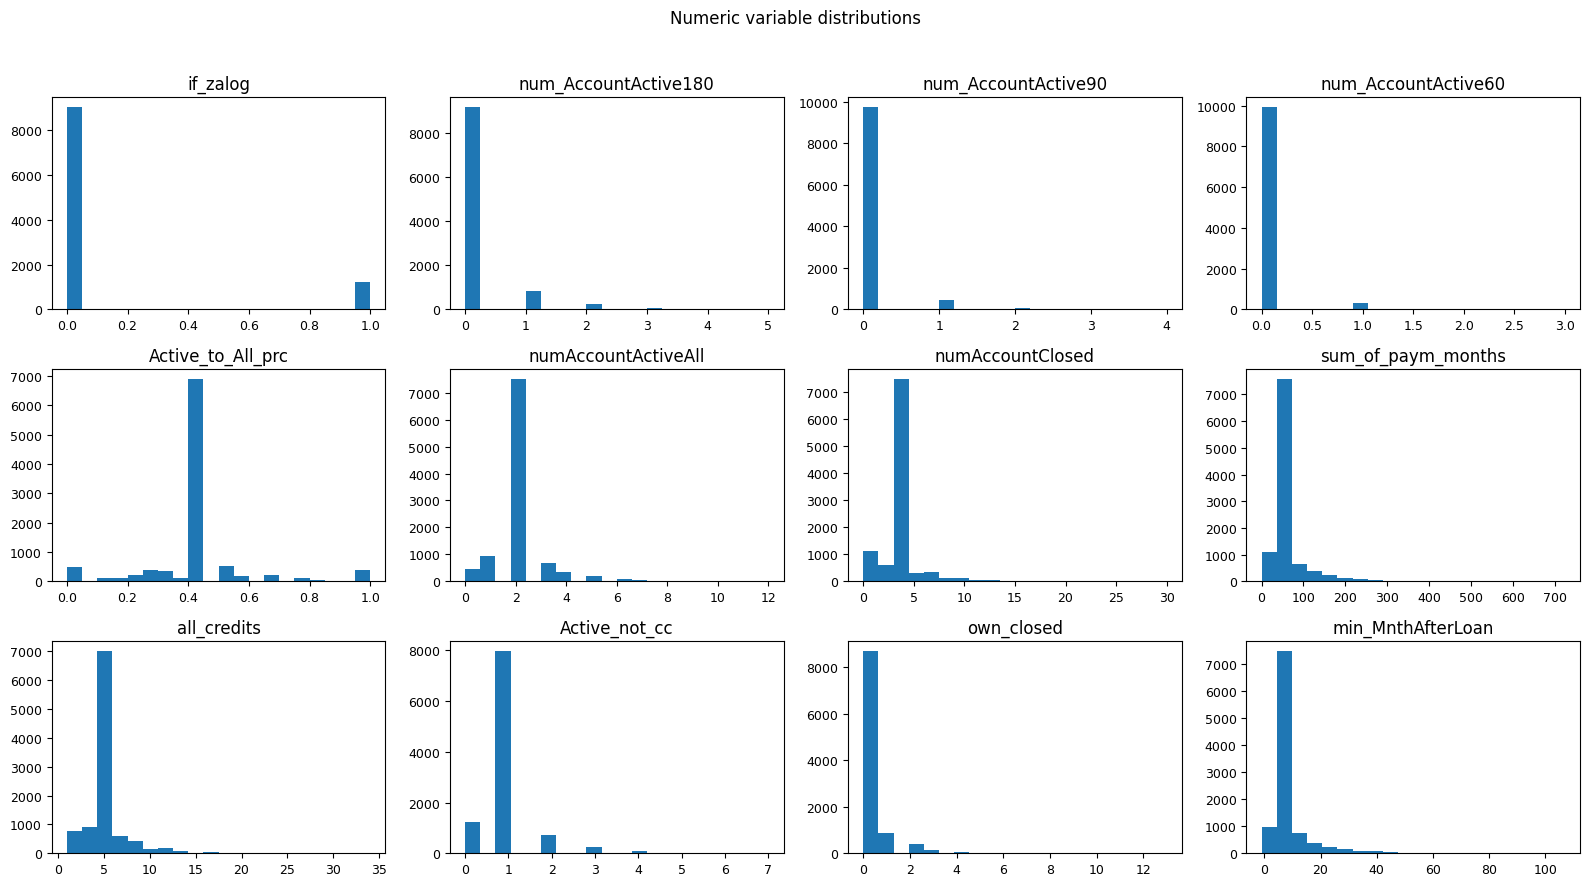

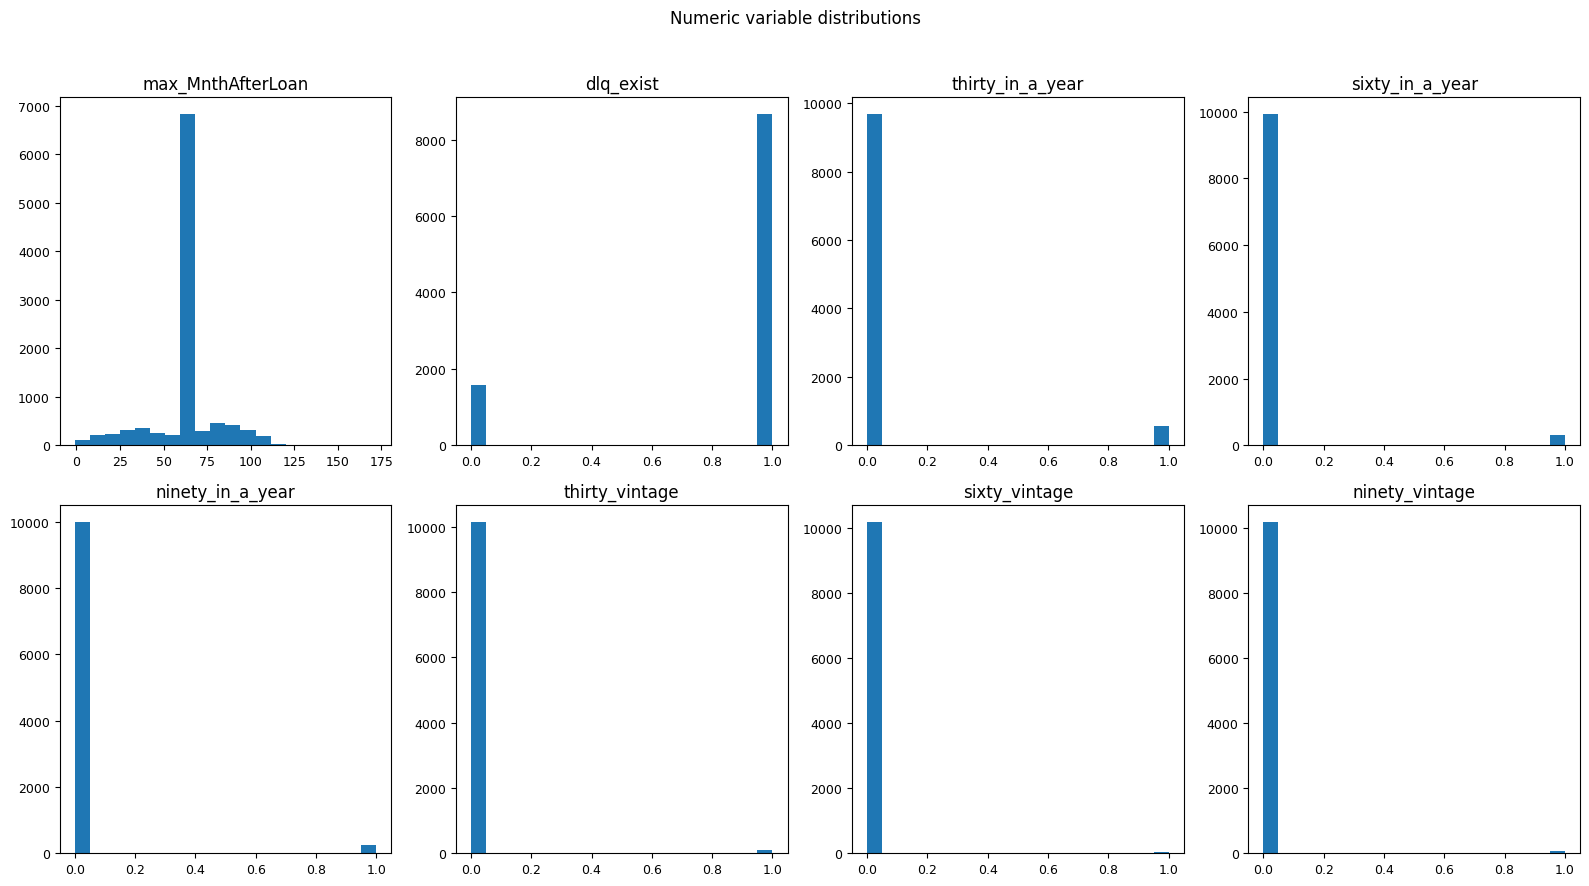

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

num_cols = df_clean.select_dtypes(include='number').columns.tolist()

plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

cols_per_row = 4
rows_per_fig = 3
batch_size = cols_per_row * rows_per_fig

for i in range(0, len(num_cols), batch_size):
    batch = num_cols[i:i+batch_size]
    n = len(batch)
    nrows = math.ceil(n / cols_per_row)
    fig, axes = plt.subplots(nrows=nrows, ncols=cols_per_row, figsize=(16, 9))
    axes = np.ravel(axes) if n > 1 else [axes]

    for ax, col in zip(axes, batch):
        ax.hist(df_clean[col].dropna(), bins=20)
        ax.set_title(col)
        ax.ticklabel_format(axis='y', style='plain')
    for ax in axes[n:]:
        ax.axis('off')

    fig.suptitle("Numeric variable distributions", y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Log-scale histograms for skewed features: ['FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'EMPL_SIZE', 'BANKACCOUNT_FLAG', 'Period_at_work', 'max90days', 'max60days', 'max30days', 'max21days', 'max14days', 'avg_num_delay', 'if_zalog', 'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60', 'Active_to_All_prc', 'numAccountActiveAll', 'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc', 'own_closed', 'min_MnthAfterLoan', 'thirty_in_a_year', 'sixty_in_a_year', 'ninety_in_a_year', 'thirty_vintage', 'sixty_vintage', 'ninety_vintage']


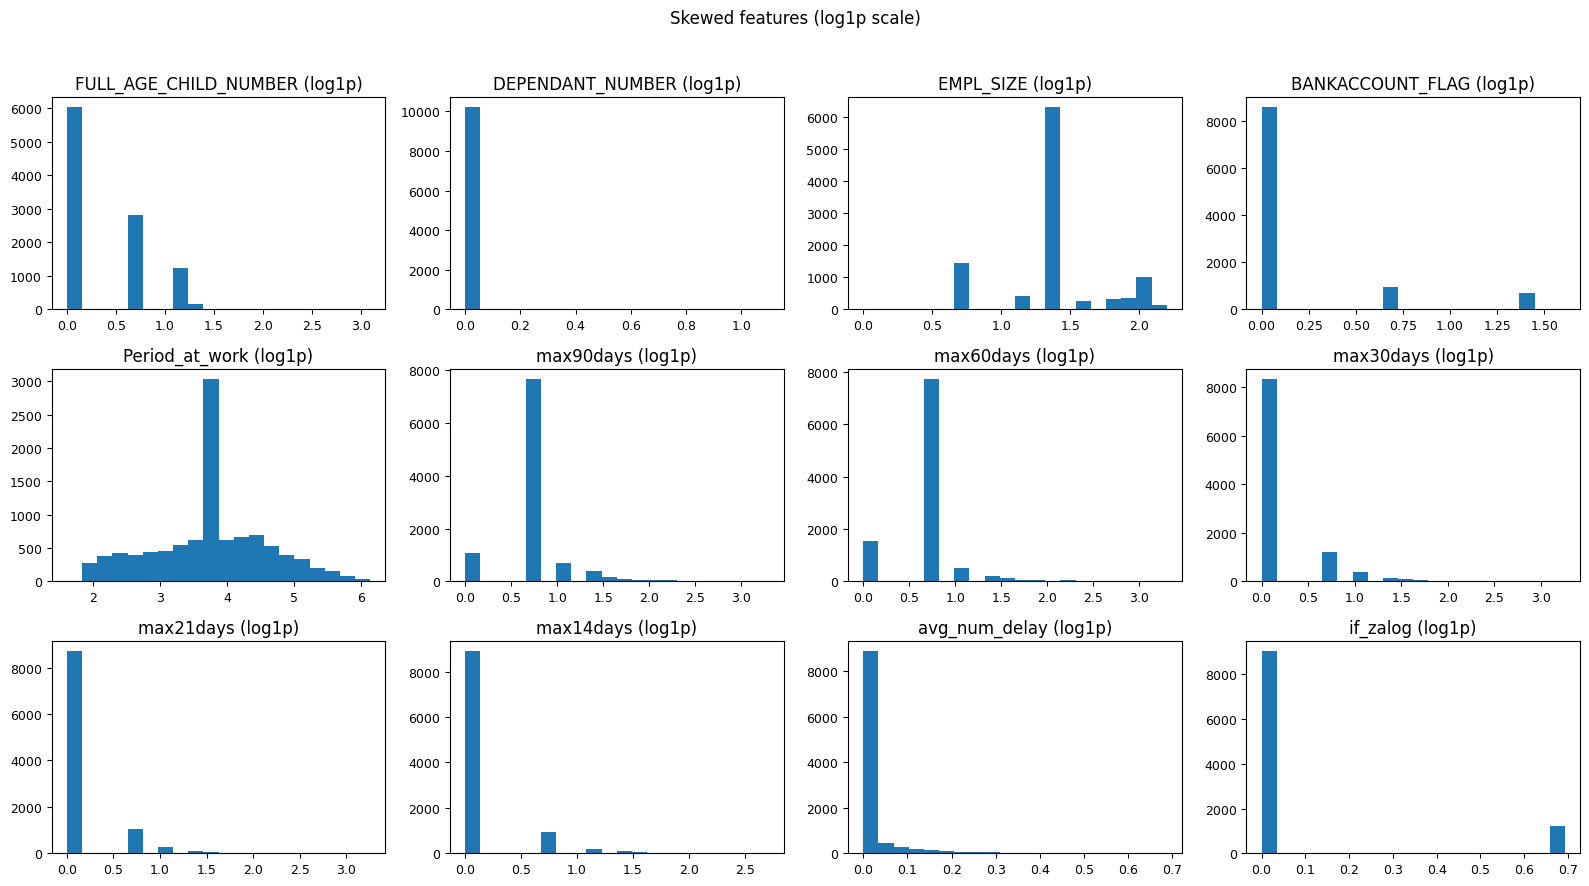

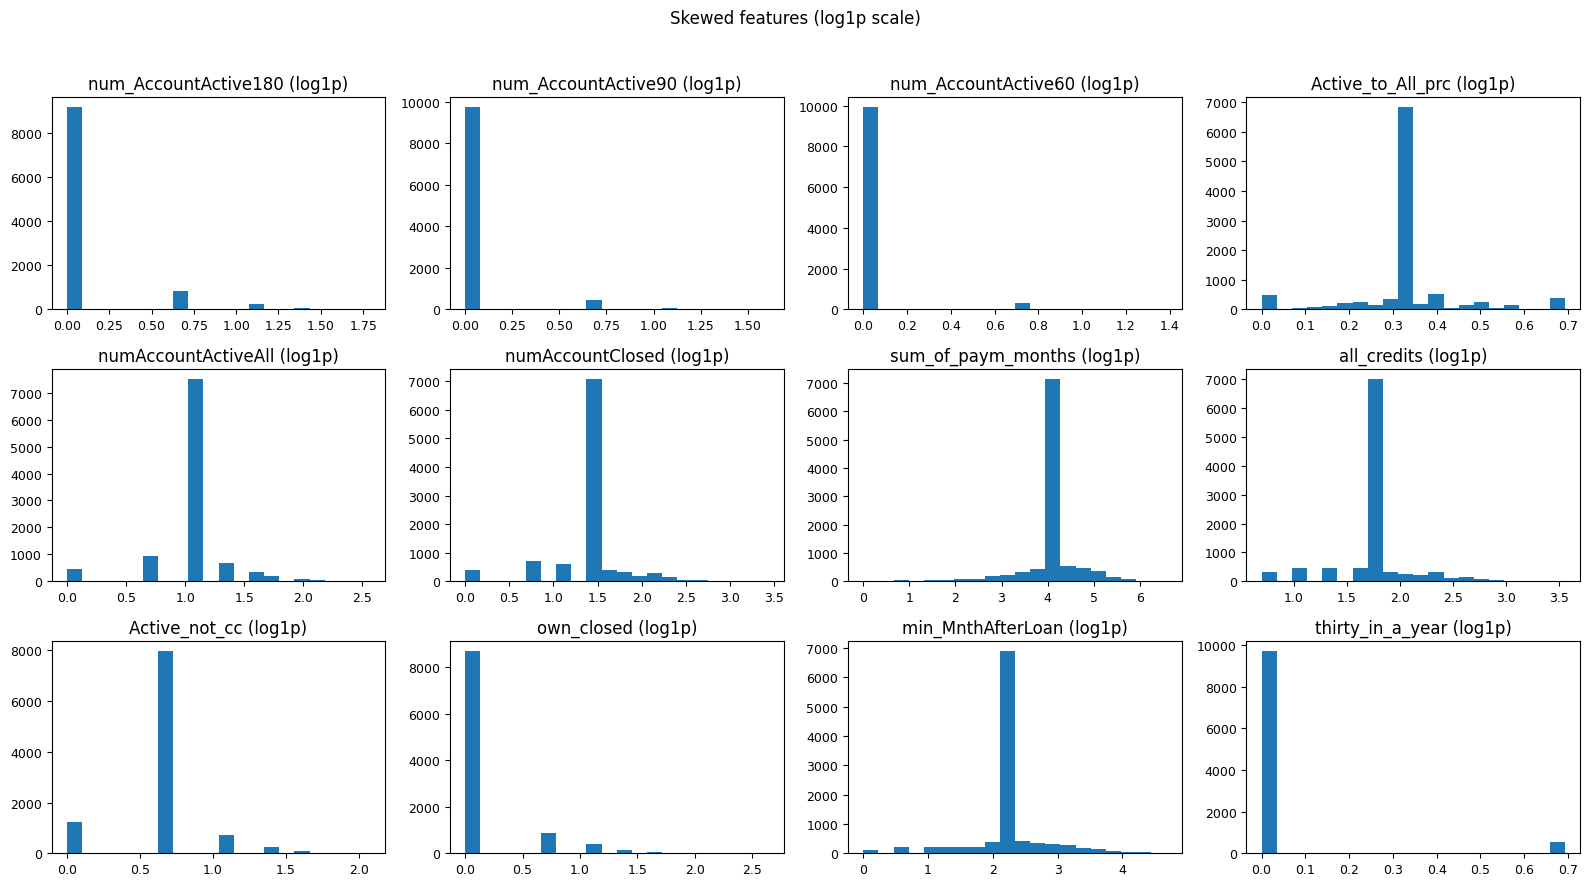

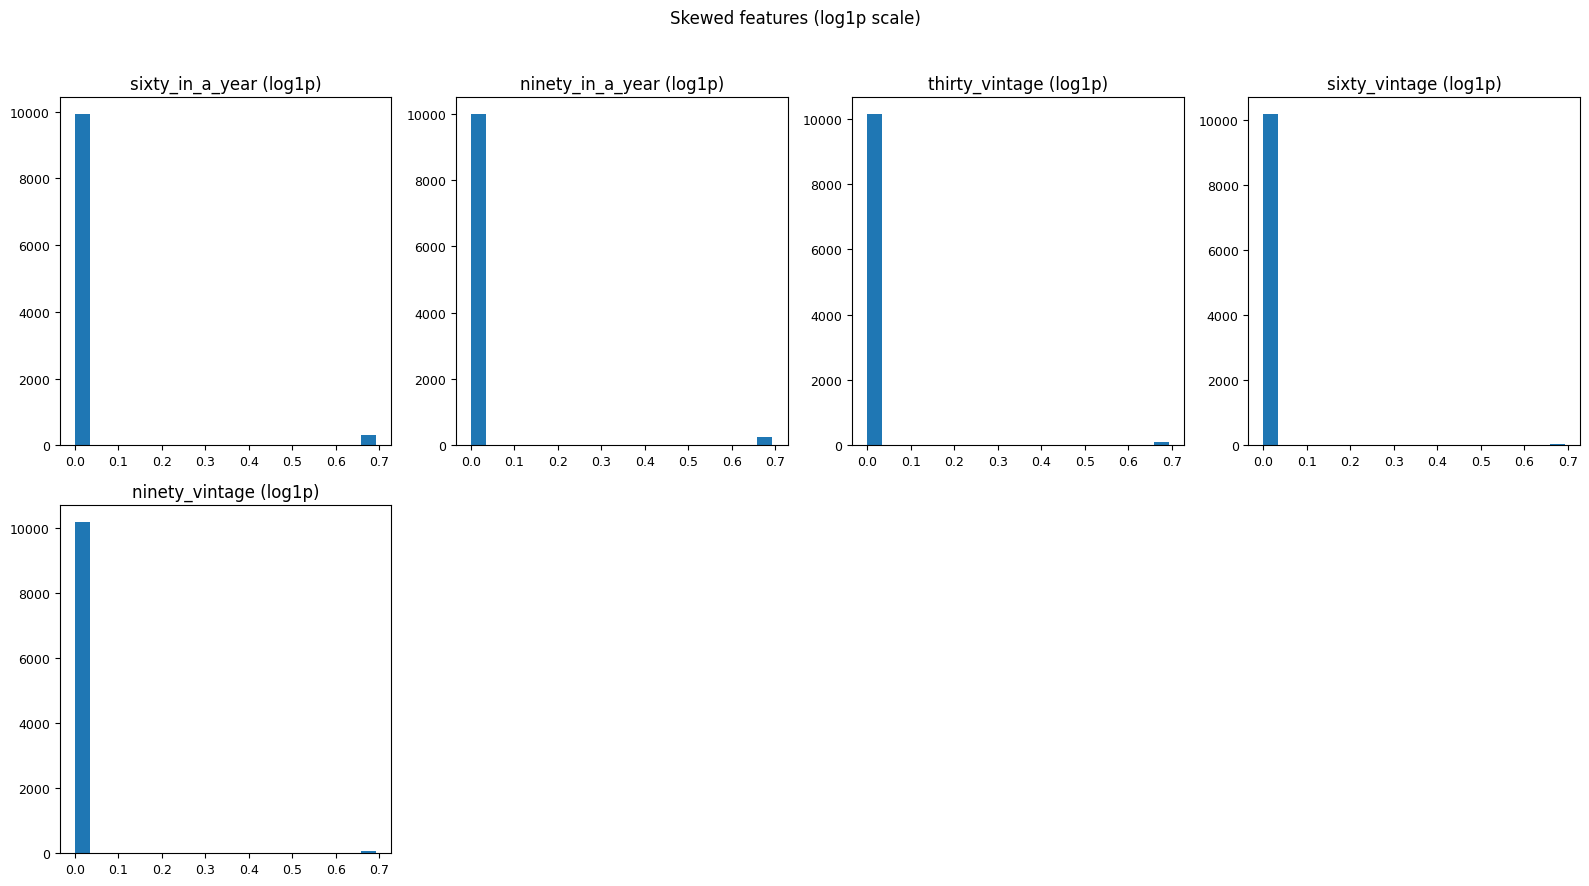

In [7]:
skewed = [c for c in num_cols if df_clean[c].dropna().skew() > 1.0]
if skewed:
    print("Log-scale histograms for skewed features:", skewed)
    cols_per_row = 4
    rows_per_fig = 3
    batch_size = cols_per_row * rows_per_fig
    for i in range(0, len(skewed), batch_size):
        batch = skewed[i:i+batch_size]
        n = len(batch)
        nrows = math.ceil(n / cols_per_row)
        fig, axes = plt.subplots(nrows=nrows, ncols=cols_per_row, figsize=(16, 9))
        axes = np.ravel(axes) if n > 1 else [axes]
        for ax, col in zip(axes, batch):
            x = df_clean[col].dropna()
            x = x[x >= 0]
            ax.hist(np.log1p(x), bins=20)
            ax.set_title(f"{col} (log1p)")
            ax.ticklabel_format(axis='y', style='plain')
        for ax in axes[n:]:
            ax.axis('off')
        fig.suptitle("Skewed features (log1p scale)", y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


/tmp/ipython-input-2817569548.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


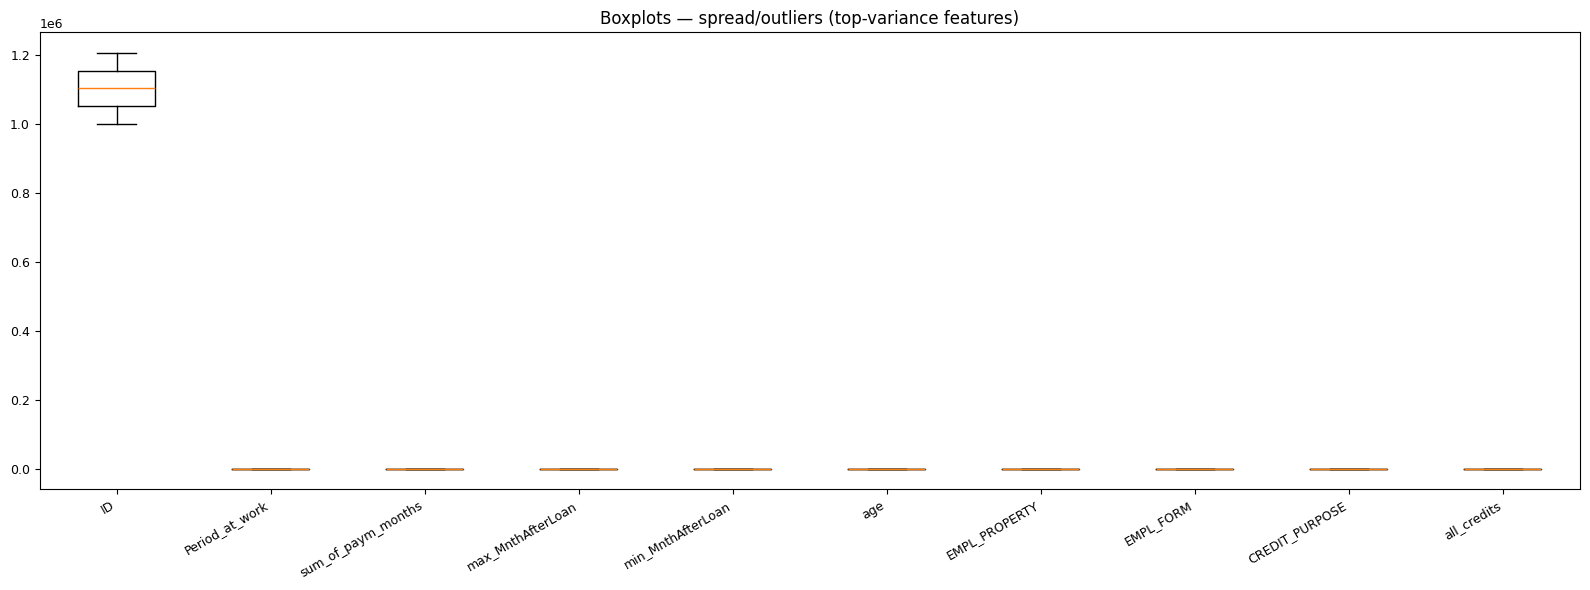

/tmp/ipython-input-2817569548.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


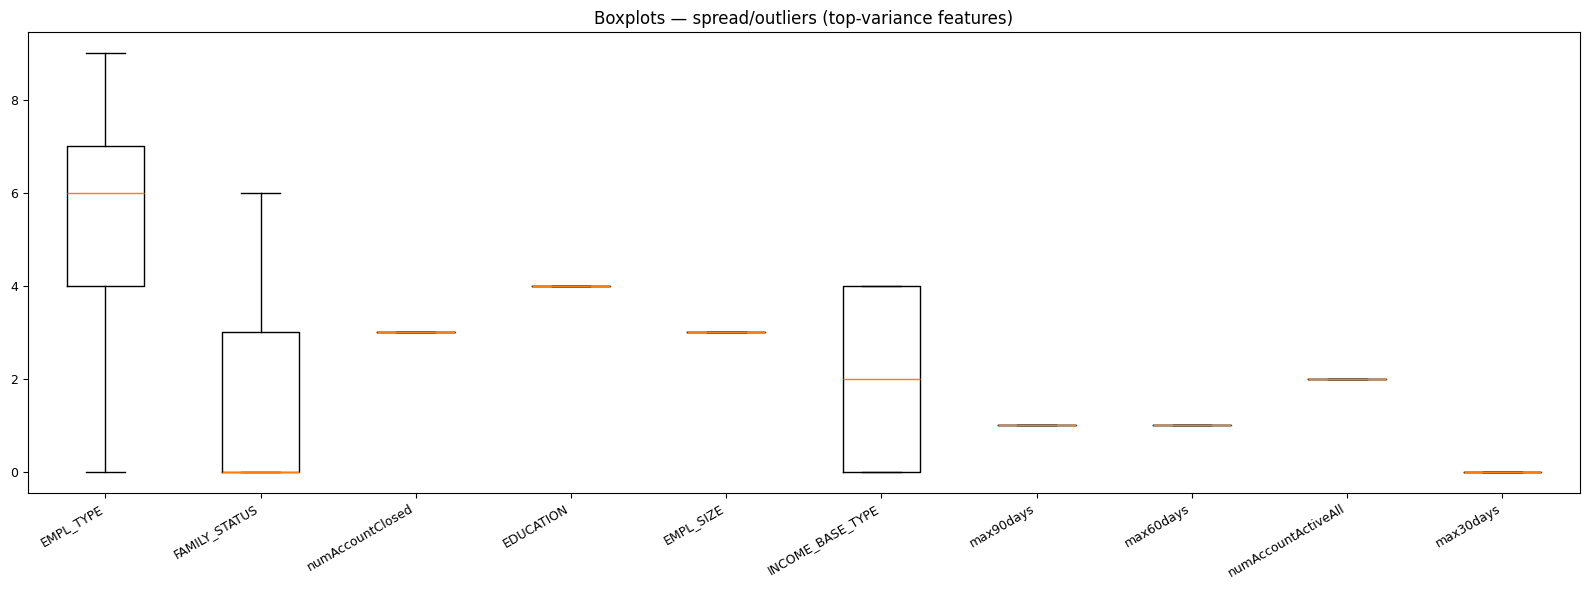

/tmp/ipython-input-2817569548.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


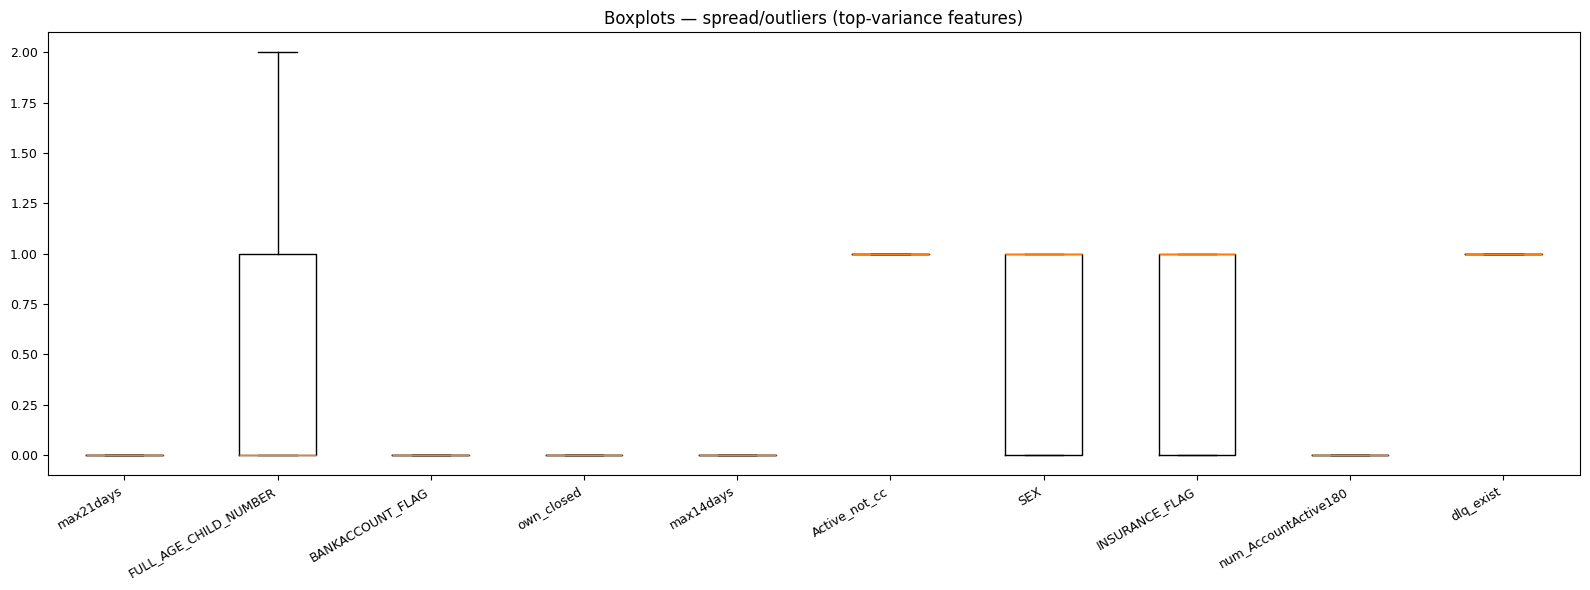

/tmp/ipython-input-2817569548.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


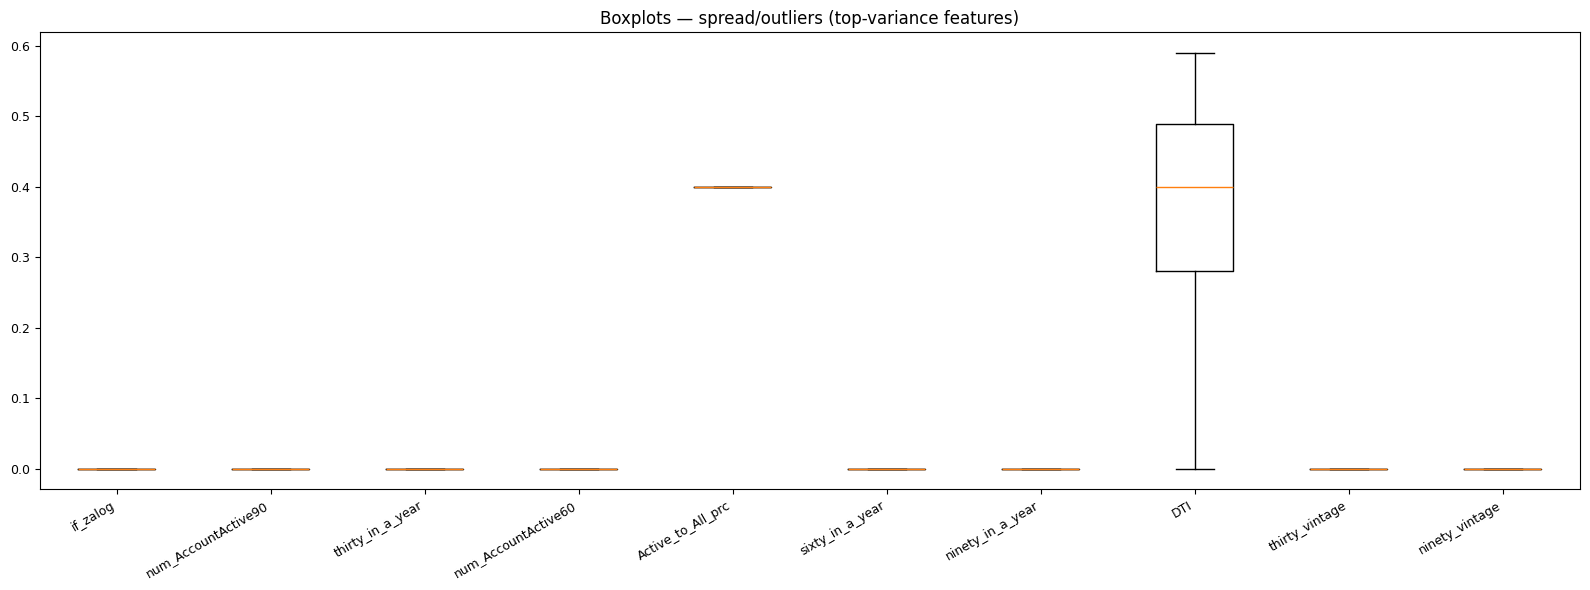

/tmp/ipython-input-2817569548.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


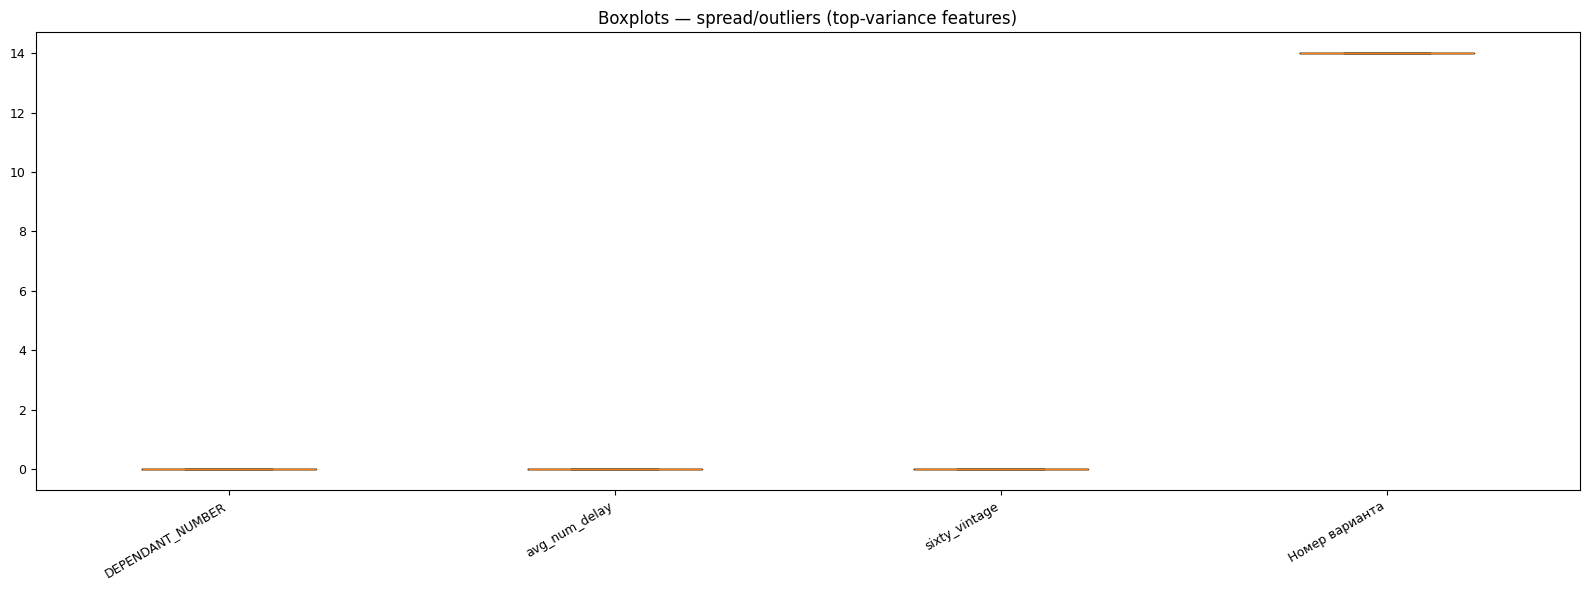

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

num_cols = df_clean.select_dtypes(include='number').columns.tolist()


variances = df_clean[num_cols].var().sort_values(ascending=False)
ordered_cols = variances.index.tolist()

batch = 10
for i in range(0, len(ordered_cols), batch):
    subset = ordered_cols[i:i+batch]
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.boxplot(
        [df_clean[c].dropna().values for c in subset],
        labels=subset,
        showfliers=False  #
    )
    ax.set_title("Boxplots — spread/outliers (top-variance features)")
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()


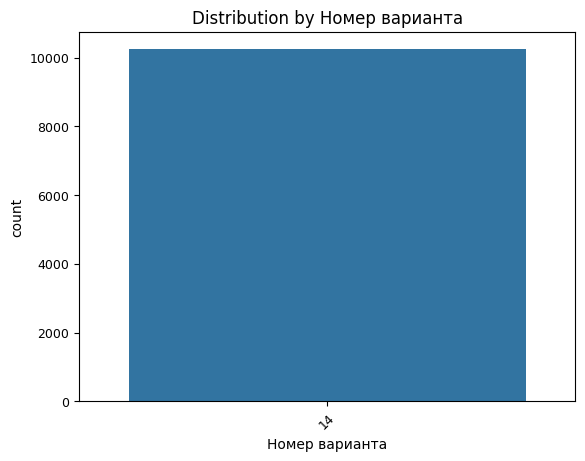

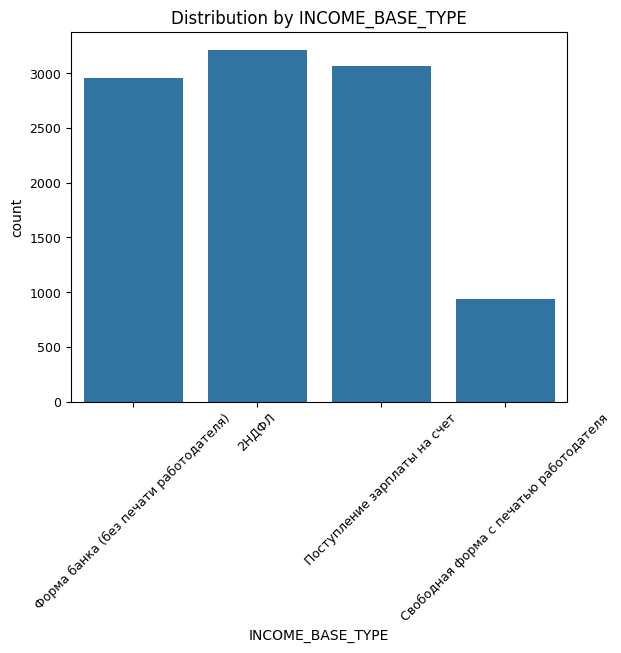

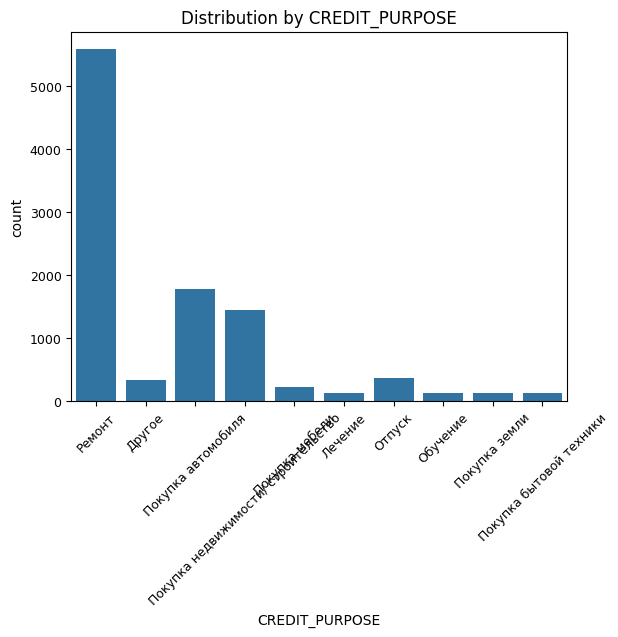

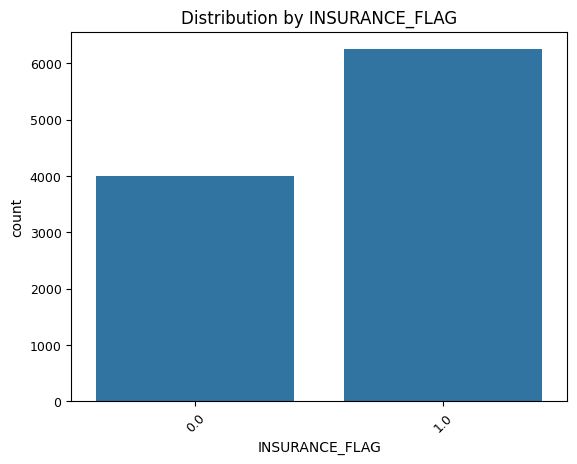

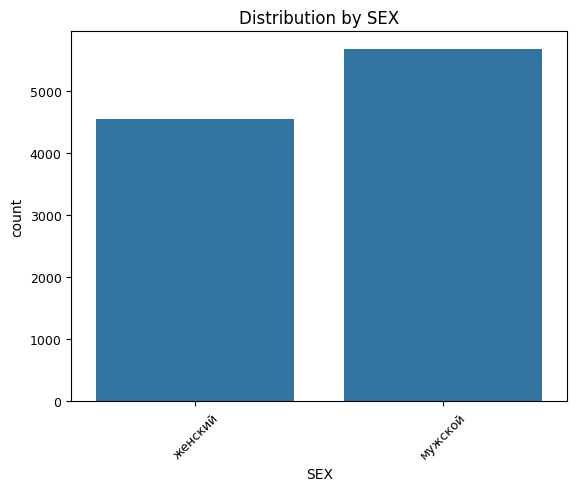

In [10]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object' or df[c].nunique() < 10]
for c in cat_cols[:5]:
    sns.countplot(x=c, data=df)
    plt.title(f"Distribution by {c}")
    plt.xticks(rotation=45)
    plt.show()


We build RFM segmentation (Recency, Frequency, Monetary).  
If no recency date, set R=0.


In [11]:
rfm = pd.DataFrame(index=df_clean.index)
rfm['R'] = 0
rfm['F'] = df_clean[[c for c in df_clean.columns if re.search('cnt|count', c, re.IGNORECASE)][0]]
rfm['M'] = df_clean[[c for c in df_clean.columns if re.search('sum|amount|limit|loan', c, re.IGNORECASE)]].sum(axis=1)

def qbin(s):
    return pd.qcut(s.rank(method='first'), 5, labels=False)

rfm['R_bin'] = 4 - qbin(rfm['R'])
rfm['F_bin'] = qbin(rfm['F'])
rfm['M_bin'] = qbin(rfm['M'])
rfm['RFM_score'] = rfm[['R_bin','F_bin','M_bin']].sum(axis=1)
rfm['segment'] = qbin(rfm['RFM_score'])
rfm.groupby('segment')[['R','F','M']].median()


,R,F,M
segment,,,
0,0.0,0.0,109.0
1,0.0,0.0,136.0
2,0.0,0.0,136.0
3,0.0,0.0,136.0
4,0.0,1.0,153.0


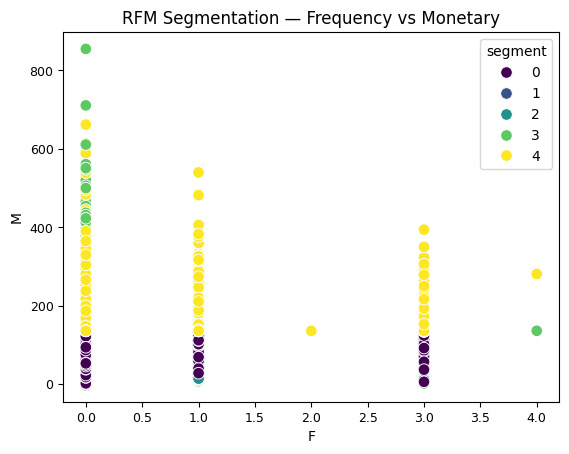

In [12]:
sns.scatterplot(x=rfm['F'], y=rfm['M'], hue=rfm['segment'], palette='viridis', s=70)
plt.title("RFM Segmentation — Frequency vs Monetary")
plt.show()


We scale numeric features for K-Means clustering.


In [13]:
X = StandardScaler().fit_transform(df_clean.select_dtypes(include='number'))


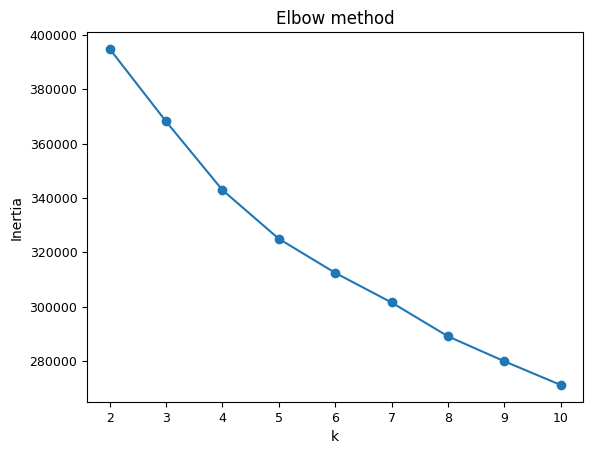

,k,silhouette,CH,DB
0,2,0.381005,1182.946663,2.464627
1,3,0.340105,1005.526838,2.170471
2,4,0.199522,970.510521,2.378668
3,5,0.206408,909.187274,2.168351
4,6,0.209646,838.590309,2.045486
5,7,0.043919,785.635000,2.094946
6,8,0.052215,765.235468,2.012010
7,9,0.062239,733.436700,2.095096
8,10,0.063290,709.339751,1.966240


In [14]:
ks = range(2, 11)
inertias, sils, chs, dbs = [], [], [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))
    chs.append(calinski_harabasz_score(X, labels))
    dbs.append(davies_bouldin_score(X, labels))

plt.plot(ks, inertias, marker='o')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

pd.DataFrame({'k':ks,'silhouette':sils,'CH':chs,'DB':dbs})


In [15]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X)
df_clean['cluster'].value_counts(normalize=True)*100


,proportion
cluster,
0,62.966218
1,22.192931
3,9.724663
2,2.704550
4,2.411638


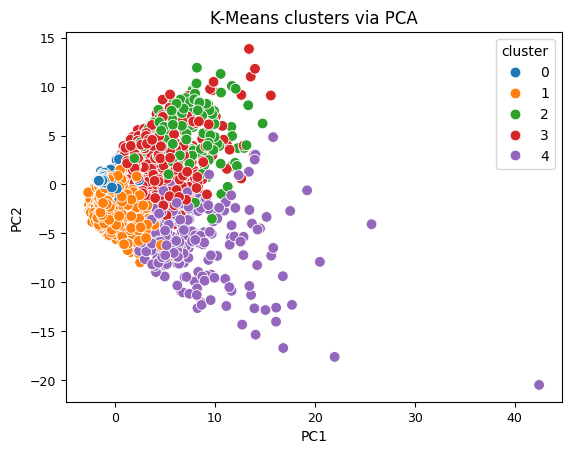

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(X_pca, columns=['PC1','PC2'])
pca_df['cluster'] = df_clean['cluster']

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=60)
plt.title('K-Means clusters via PCA')
plt.show()


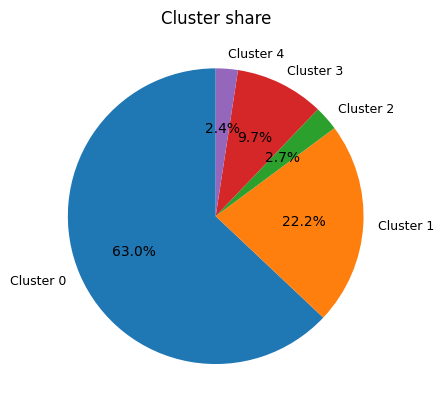

In [17]:
cluster_counts = df_clean['cluster'].value_counts().sort_index()
plt.pie(cluster_counts, labels=[f"Cluster {i}" for i in cluster_counts.index], autopct='%1.1f%%', startangle=90)
plt.title("Cluster share")
plt.show()


In [18]:
profile = df_clean.groupby('cluster').median(numeric_only=True)
profile['count'] = df_clean.groupby('cluster').size()
profile['share_%'] = (profile['count']/len(df_clean)*100).round(1)
profile


,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,...,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage,count,share_%
cluster,,,,,,,,,,,,,,,,,,,,,
0,14.0,1107734.0,2.0,9.0,1.0,0.40,1.0,0.0,0.0,4.0,...,65.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6449,63.0
1,14.0,1081134.0,2.0,9.0,1.0,0.37,1.0,0.0,0.0,4.0,...,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2273,22.2
2,14.0,1114174.0,2.0,9.0,1.0,0.41,1.0,0.0,0.0,4.0,...,86.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,277,2.7
3,14.0,1100724.0,3.0,9.0,1.0,0.46,0.0,0.0,0.0,4.0,...,84.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,996,9.7
4,14.0,1121894.0,0.0,9.0,1.0,0.42,1.0,0.0,0.0,4.0,...,62.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,247,2.4


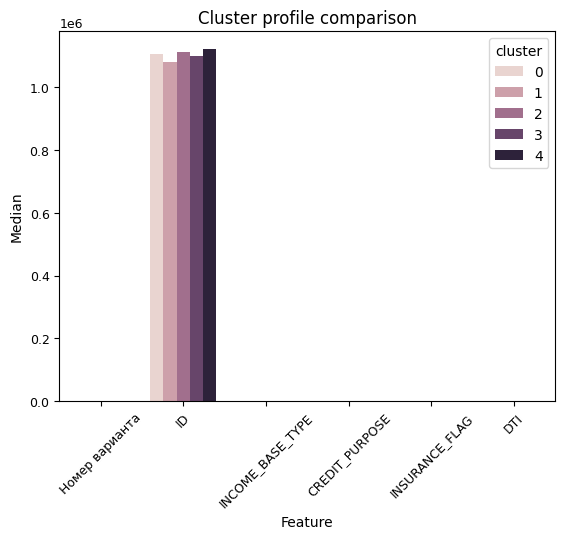

In [19]:
key_features = df_clean.select_dtypes(include='number').columns[:6]
cluster_summary = df_clean.groupby('cluster')[key_features].median().reset_index()
melted = cluster_summary.melt(id_vars='cluster', var_name='Feature', value_name='Median')

sns.barplot(data=melted, x='Feature', y='Median', hue='cluster')
plt.title('Cluster profile comparison')
plt.xticks(rotation=45)
plt.show()


In [20]:
df_clean.to_csv('final_datamart_var14.csv', index=False)
rfm_out = rfm[['RFM_score','segment']]
rfm_out['cluster'] = df_clean['cluster']
rfm_out.to_csv('segmentation_outputs_var14.csv', index=False)
print("Files saved: final_datamart_var14.csv, segmentation_outputs_var14.csv")


Files saved: final_datamart_var14.csv, segmentation_outputs_var14.csv


/tmp/ipython-input-3139441595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_out['cluster'] = df_clean['cluster']
